# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## [Final Project] Social Media Toxicity Shield: Milestone 4


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

In [ ]:
# Library Imports
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from collections import Counter\

from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall, MeanIoU, AUC
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

<a id="contents"></a>
# Table of Contents
1. [**Problem Statement Refinement and Introduction**](#intro)
2. [**Comprehensive EDA Review**](#eda)
    - [**Key EDA Findings**](#find)
    - [**Preprocessing**](#preprocess)
        - [**Missing Data**](#missing)
        - [**Data Imbalance**](#imbalance)
        - [**Split Train / Test Data**](#split)
3. [**Modeling**](#model)
    - [**Baseline Model Choice**](#choice)
    - [**Training Process**](#train)
    - [**Initial Results**](#result)
4. [**Results Interpretation & Analysis**](#interp)
    - [**Analysis of Baseline Model Performance**](#analysis)
    - [**Proposed Improvements**](#improve)
5. [**Final Model Pipeline**](#final)
    - [**Assumptions, Parameter Choices, and Preliminary Tuning Considerations**](#assum)

<a id="intro"></a>

# 1. Problem Statement Refinement and Introduction

[Return to contents](#contents)

## Introduction
Toxic content on online platforms have been a persistent issue, contributing to mental health challenges like anxiety and depression. With harmful posts impacting well-being, proactive measures are crucial. This project seeks to protect users through real-time toxicity detection and immediate mental health support, promoting healthier online interactions.

## Problem Statement

<a id="eda"></a>

# 2. Comprehensive EDA Review
[Return to contents](#contents)

<a id="find"></a>

## Key EDA Findings
[Return to contents](#contents)

<a id="preprocess"></a>

## Preprocessing
[Return to contents](#contents)

<a id="missing"></a>

### Missing Data

<a id="imbalance"></a>

### Data Imbalance

<a id="split"></a>

### Split Train / Test Data

<a id="model"></a>

# 3. Modeling
[Return to contents](#contents)

<a id="choice"></a>

## Baseline Model Choice
[Return to contents](#contents)

<a id="train"></a>

## Training Process
[Return to contents](#contents)

<a id="result"></a>

## Initial Results
[Return to contents](#contents)

<a id="interp"></a>

# 4. Results Interpretation & Analysis
[Return to contents](#contents)

<a id="analysis"></a>

## Analysis of Baseline Model Performance
[Return to contents](#contents)

<a id="improve"></a>

## Proposed Improvements
[Return to contents](#contents)

<a id="final"></a>

# 5. Final Model Pipeline
[Return to contents](#contents)

<a id="assum"></a>

## Assumptions, Parameter Choices, and Preliminary Tuning Considerations
[Return to contents](#contents)

# 1. Problem Statement Refinement and introduction:

Develop an introduction to your project.
Reiterate/refine your problem statement if needed. Ensure it is clear and understandable to someone outside your field.
Articulate significance based on new insights from EDA, highlighting shifts in perspective or understanding.

* clear and concise problem statement 

### Data Description & Addressing Feedback

Our feedback from MS2 asked how we plan to evaluate the fairness of our model using the identity columns (e.g., `female`, `black`, `muslim`, etc.). These columns indicate whether a comment references that specific identity. These identities will not be used during training, but we will use it in our post-training fairness evaluation. We will include group-wise performance metrics, assessing how the model performs within each identity subgroup including: true positive rate; false positive rate; and precision, recall, and F1-scores. This will allow us to see if the model is disproportionately flagging non-toxic comments as toxic for certain groups. Then, we can also do subgroup fairness metrics like subgroup AUC for distinguishing toxic vs. non-toxic comments within the subgroup; BPSN AUC (background positive, subgroup negative) for comparing non-toxic subgroup comments vs. toxic background comments; and BNSP AUC (background negative, subgroup positive) for comparing toxic subgroup comments vs. non-toxic background comments.

Once again, we are using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains ~1.9 million online comments labeled for various forms of toxicity. In MS2, after cleaning and subsetting, our final dataset includes comment_text as input and seven binary toxicity labels as outputs (toxic, insult, threat). The data is highly imbalanced, with most toxicity categories appearing in less than 10% of the samples.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import seaborn as sns
import csv
import os
%matplotlib inline

### Loading Data

In [2]:
df_cleaned = pd.read_csv("cleaned_ms2_data.csv")
df_cleaned.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0
3,59855,Is this something I'll be able to install on m...,0,0,0,0,0,0,0
4,59856,haha you guys are a bunch of losers.,1,0,0,0,1,0,0


In [3]:
print("Shape:", df_cleaned.shape)

Shape: (1902191, 9)


In [4]:
print("Data types:\n", df_cleaned.dtypes)

Data types:
 id                  int64
comment_text       object
toxic               int64
severe_toxicity     int64
obscene             int64
identity_attack     int64
insult              int64
threat              int64
sexual_explicit     int64
dtype: object


In [5]:
print("Descriptive statistics:\n", df_cleaned.describe())

Descriptive statistics:
                  id         toxic  severe_toxicity       obscene  \
count  1.902191e+06  1.902191e+06     1.902191e+06  1.902191e+06   
mean   3.912770e+06  7.996621e-02     6.834224e-06  5.333849e-03   
std    2.497349e+06  2.712409e-01     2.614227e-03  7.283819e-02   
min    5.984800e+04  0.000000e+00     0.000000e+00  0.000000e+00   
25%    8.273535e+05  0.000000e+00     0.000000e+00  0.000000e+00   
50%    5.282204e+06  0.000000e+00     0.000000e+00  0.000000e+00   
75%    5.862734e+06  0.000000e+00     0.000000e+00  0.000000e+00   
max    7.194639e+06  1.000000e+00     1.000000e+00  1.000000e+00   

       identity_attack        insult        threat  sexual_explicit  
count     1.902191e+06  1.902191e+06  1.902191e+06     1.902191e+06  
mean      7.410928e-03  5.904244e-02  2.366219e-03     2.589645e-03  
std       8.576718e-02  2.357042e-01  4.858622e-02     5.082264e-02  
min       0.000000e+00  0.000000e+00  0.000000e+00     0.000000e+00  
25%       0.

From this, we can numerically see the class imbalance. Let's look at it graphically.

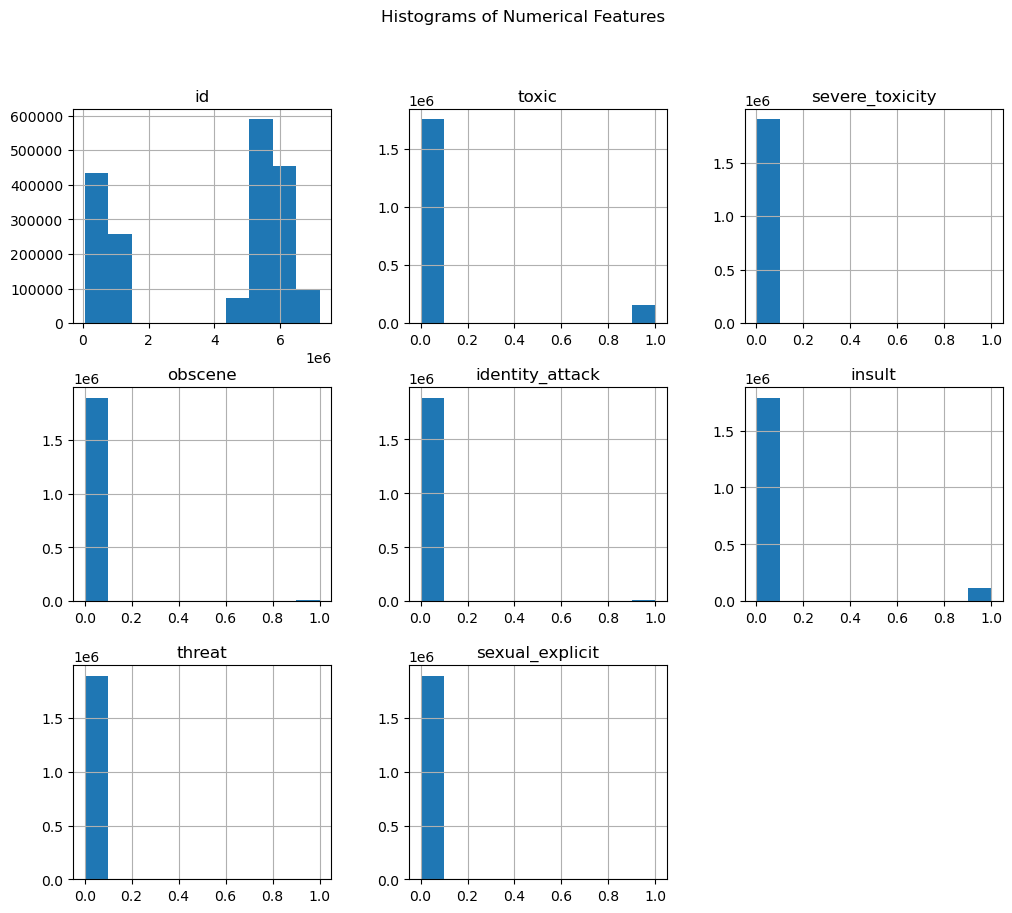

In [6]:
df_cleaned.hist(bins=10, figsize=(12, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()


We can again see that there is a large class imbalance. To mitigate this, we will include `severe_toxic` in the `toxic` category. 

In [7]:
df_cleaned['toxic'] = df_cleaned['toxic'] | df_cleaned['severe_toxicity']
df_cleaned = df_cleaned.drop(columns=['severe_toxicity'])


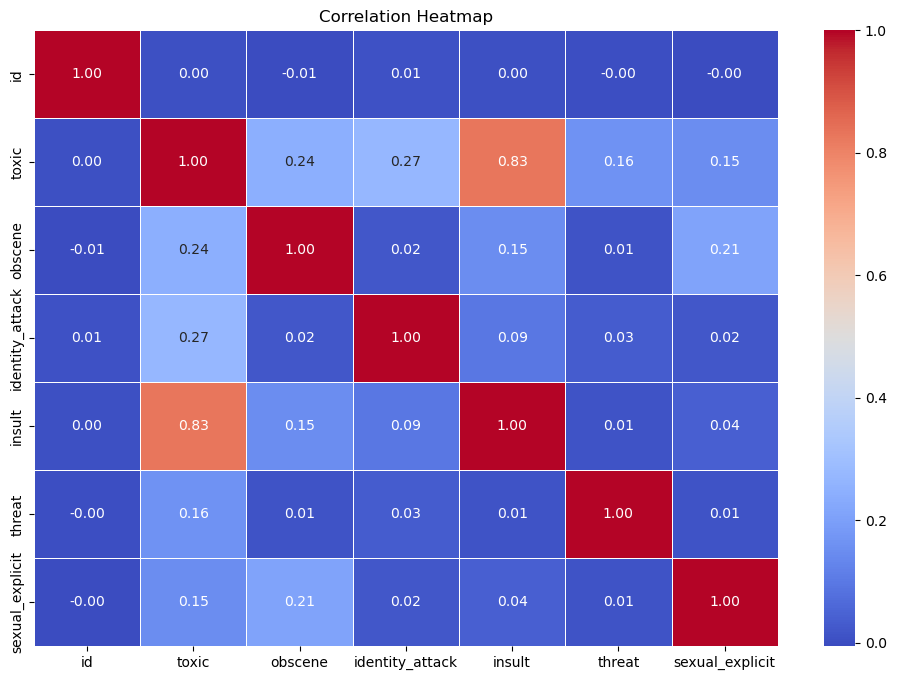

In [8]:
# correlation matrix and heatmap for numeric columns
corr = df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


There is a strong correlation of 0.83 between `toxic` and `insult`, which makes sense. The correlation between `toxic` and `obscene` is moderate at 0.24. This relationship is not as strong as with insults. There is a moderate correlation of 0.27 between `toxic` and `identity_attack`. The correlation between `insult` and `identity_attack` is also moderate at 0.15. The `threat` label has very weak correlations with all other columns (all near 0.00 surprisingly), suggesting that threats seem to be independent of other forms of toxicity. There is a moderate correlation of 0.21 between `sexual_explicit` and `obscene`, and a moderate correlation of 0.15 between `sexual_explicit` and `toxic`.

We will now address the class imbalance by oversampling the `toxic` class.

In [9]:
# Used help from ChatGPT on this part - I didn't know there was a resample object in sklearn library
from sklearn.utils import resample

toxic = df_cleaned[df_cleaned['toxic'] == 1]
non_toxic = df_cleaned[df_cleaned['toxic'] == 0]

# Oversample toxic comments
toxic_upsampled = resample(toxic, 
                           replace=True,
                           n_samples=len(non_toxic),  
                           random_state=109) 

df_balanced = pd.concat([toxic_upsampled, non_toxic])

print(df_balanced['toxic'].value_counts())

toxic
1    1750080
0    1750080
Name: count, dtype: int64


Let's recompute correlations.

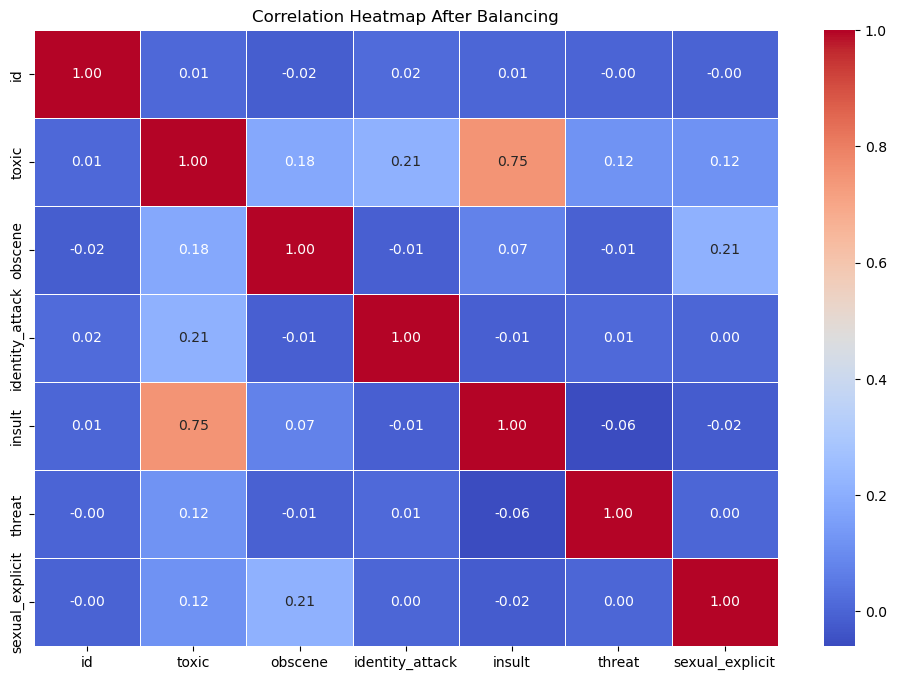

In [10]:
corr_balanced = df_balanced.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_balanced, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Balancing")
plt.show()


The heatmap largely looks the same as before, except with minor changes.

### Exploratory Data Analysis

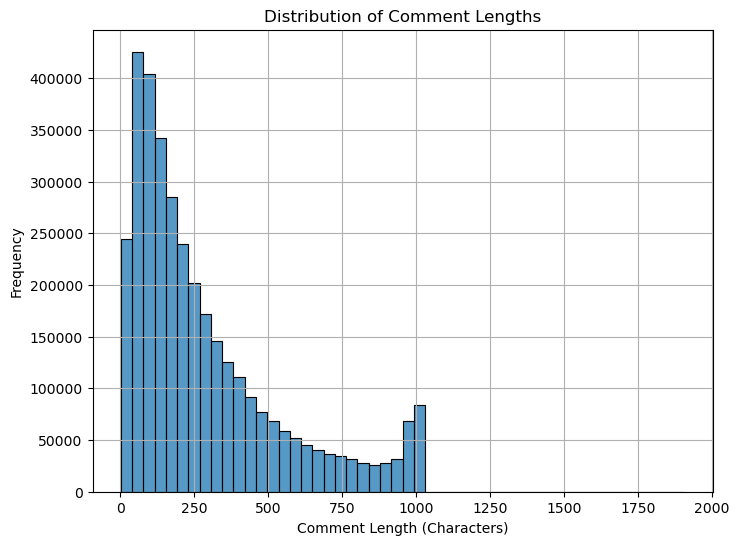

In [11]:
# Distribution of comment length
df_balanced['text_length'] = df_balanced['comment_text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df_balanced['text_length'], bins=50)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (Characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows a right-skewed distribution. Most comments are relatively short (under 250 characters). After 1000 characters, there is almost a complete drop off.

/var/folders/9q/_vz2q0v55lgfkhm60qn5nqbm0000gn/T/ipykernel_95045/471384620.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Non-' + label, label])
/var/folders/9q/_vz2q0v55lgfkhm60qn5nqbm0000gn/T/ipykernel_95045/471384620.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Non-' + label, label])
/var/folders/9q/_vz2q0v55lgfkhm60qn5nqbm0000gn/T/ipykernel_95045/471384620.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Non-' + label, label])
/var/folders/9q/_vz2q0v55lgfkhm60qn5nqbm0000gn/T/ipykernel_95045/471384620.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[

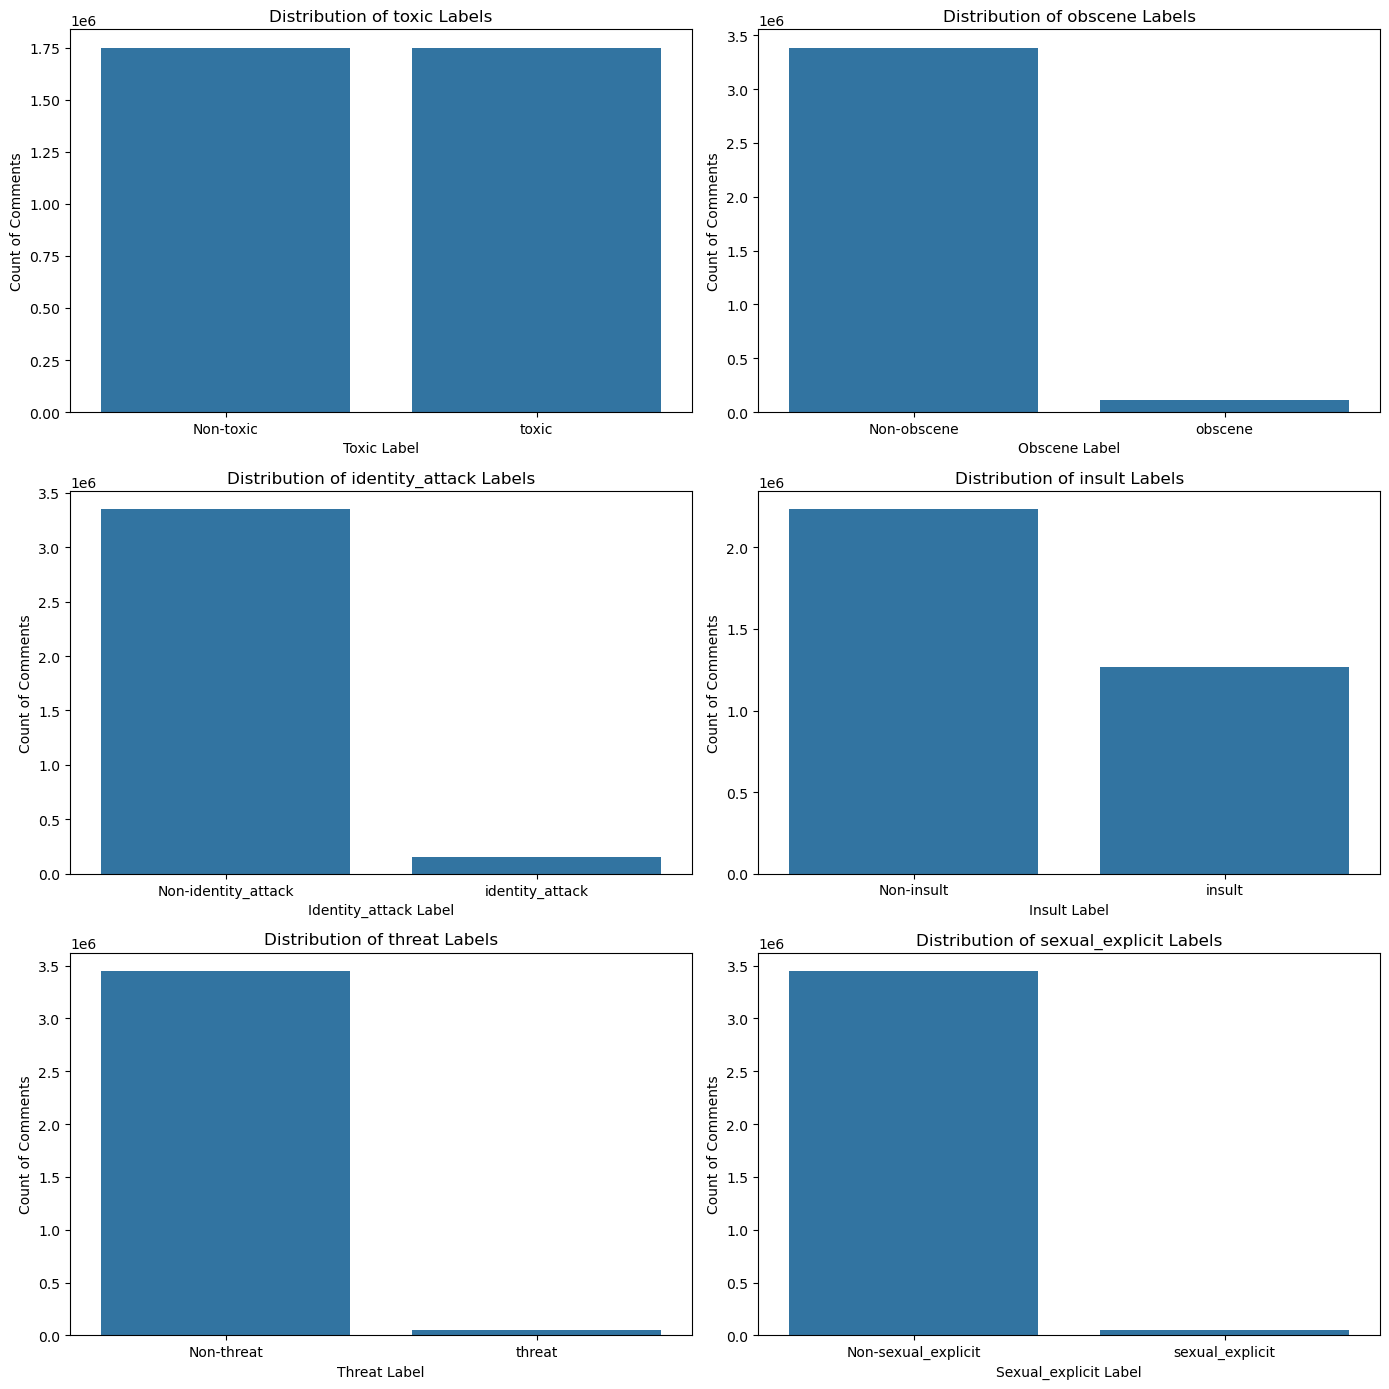

In [12]:
# Other distributions
toxicity_labels = ['toxic', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for i, label in enumerate(toxicity_labels):
    sns.countplot(x=label, data=df_balanced, ax=axes[i])
    axes[i].set_title(f"Distribution of {label} Labels")
    axes[i].set_xlabel(f"{label.capitalize()} Label")
    axes[i].set_ylabel("Count of Comments")
    axes[i].set_xticklabels(['Non-' + label, label])

plt.tight_layout()
plt.show()


The labels, with the exception of `toxic`, are heavily imbalanced. `insult` also seems to be relatively balanced. We will not be balancing the other predictors other toxicity labels because our predictive model is solely focused on predicting the toxic label, and the other toxicity labels are being used mainly for evaluation purposes. We will discuss how we plan on addressing the other class imbalances in our baseline model implementation plan.

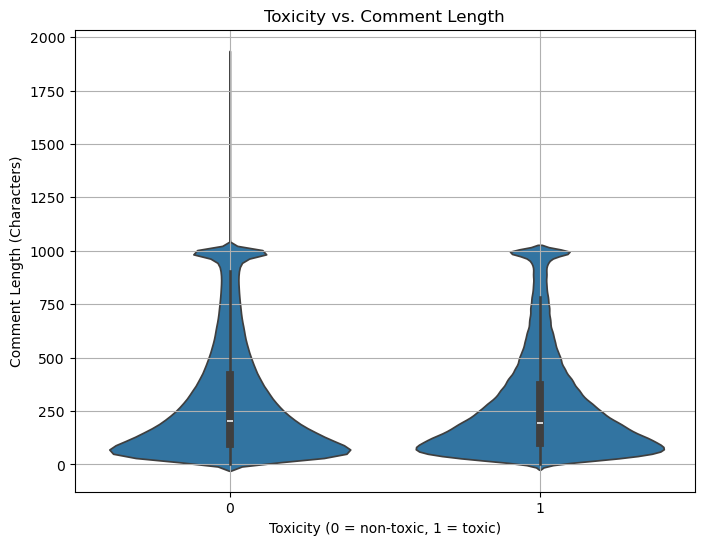

In [13]:
# violin plot for toxicity vs comment length
plt.figure(figsize=(8, 6))
sns.violinplot(x='toxic', y='text_length', data=df_balanced)
plt.title("Toxicity vs. Comment Length")
plt.xlabel("Toxicity (0 = non-toxic, 1 = toxic)")
plt.ylabel("Comment Length (Characters)")
plt.grid(True)
plt.show()



The violin plot shows that the comment length for both toxic and non-toxic comments are fairly similar ranging. The median comment length in both seems to be around 250 characters. We can see, then, that toxicity does not seem to be very dependent on comment length.

Most frequent words in toxic comments:
          Word      Frequency
16       trump  183555.940642
6         know  151855.042812
4   government  151100.043515
8         make  150964.482130
2          don  106099.290309
13       state  101597.169298
15        time   75458.004427
11      people   75268.840374
14       think   75198.529802
5         just   71861.586678

Most frequent words in non-toxic comments:
      Word      Frequency
11  people  132593.950119
5     just  128017.626590
7     like  124639.303003
16   trump  110966.010381
2      don  103132.197192
15    time   86166.476181
3     good   79139.639950
14   think   78163.997411
12   right   72222.568724
6     know   72066.636907


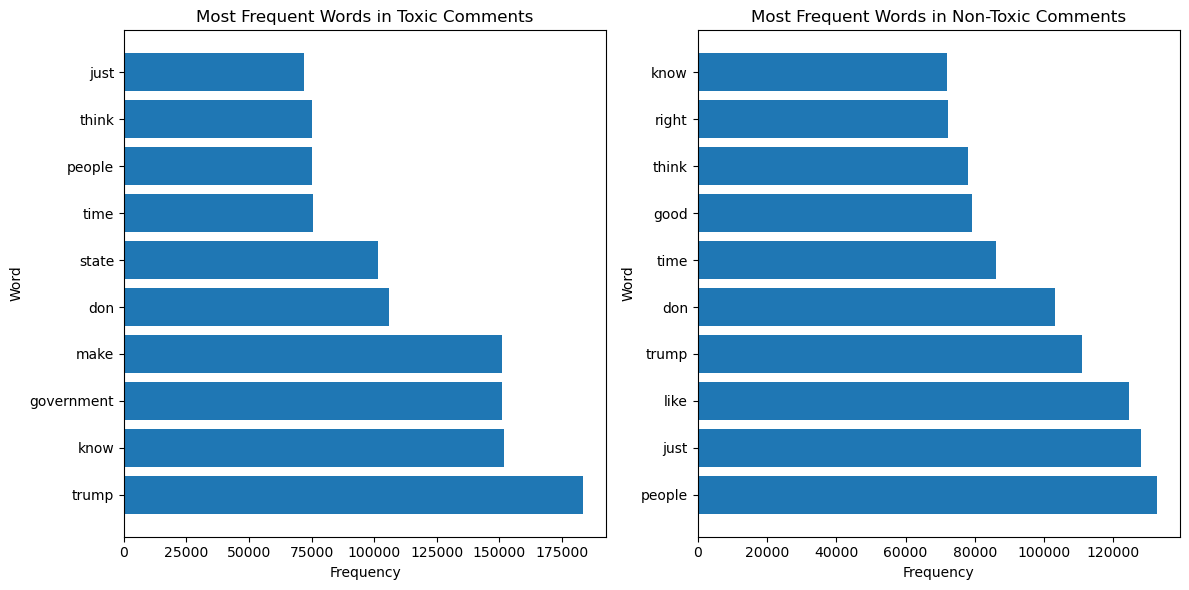

In [14]:
# Got this from ChatGPT - thought it was pretty cool
# The code separates toxic/non-toxic comments from the dataset and converts into numerical representations 
# Uses TF-IDF (Term Frequency - Inverse Document Frequency), which measures importance of words in each comment
# Then calculates most frequent words in both toxic and non-toxic comments 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Separate toxic and non-toxic comments
toxic_comments = df_balanced[df_balanced['toxic'] == 1]['comment_text']
non_toxic_comments = df_balanced[df_balanced['toxic'] == 0]['comment_text']

# Convert text data into word count vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)

# Fit vectorizer on toxic and non-toxic comments
toxic_tfidf = vectorizer.fit_transform(toxic_comments)
non_toxic_tfidf = vectorizer.fit_transform(non_toxic_comments)

# Get most frequent words
toxic_words = vectorizer.get_feature_names_out()
toxic_word_freq = toxic_tfidf.sum(axis=0).A1
non_toxic_words = vectorizer.get_feature_names_out()
non_toxic_word_freq = non_toxic_tfidf.sum(axis=0).A1

# data frame
toxic_word_freq_df = pd.DataFrame(list(zip(toxic_words, toxic_word_freq)), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False)
non_toxic_word_freq_df = pd.DataFrame(list(zip(non_toxic_words, non_toxic_word_freq)), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False)

print("Most frequent words in toxic comments:")
print(toxic_word_freq_df.head(10))

print("\nMost frequent words in non-toxic comments:")
print(non_toxic_word_freq_df.head(10))

plt.figure(figsize=(12, 6))

# Toxic
plt.subplot(1, 2, 1)
plt.barh(toxic_word_freq_df['Word'].head(10), toxic_word_freq_df['Frequency'].head(10))
plt.title("Most Frequent Words in Toxic Comments")
plt.xlabel('Frequency')
plt.ylabel('Word')

# Non-toxic
plt.subplot(1, 2, 2)
plt.barh(non_toxic_word_freq_df['Word'].head(10), non_toxic_word_freq_df['Frequency'].head(10))
plt.title("Most Frequent Words in Non-Toxic Comments")
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()


Words like "trump," "don," "time," "people," "just," and "think" appear in both toxic and non-toxic comments. We wonder if "trump" refers to President Trump and "don" refers to Donald. What is interesting is that  certain words like "government" and "state" appear frequently in toxic comments. Political topics may include a lot more toxicity in this dataset. Then, words like "like," "good," and "right" appear more often in non-toxic comments.

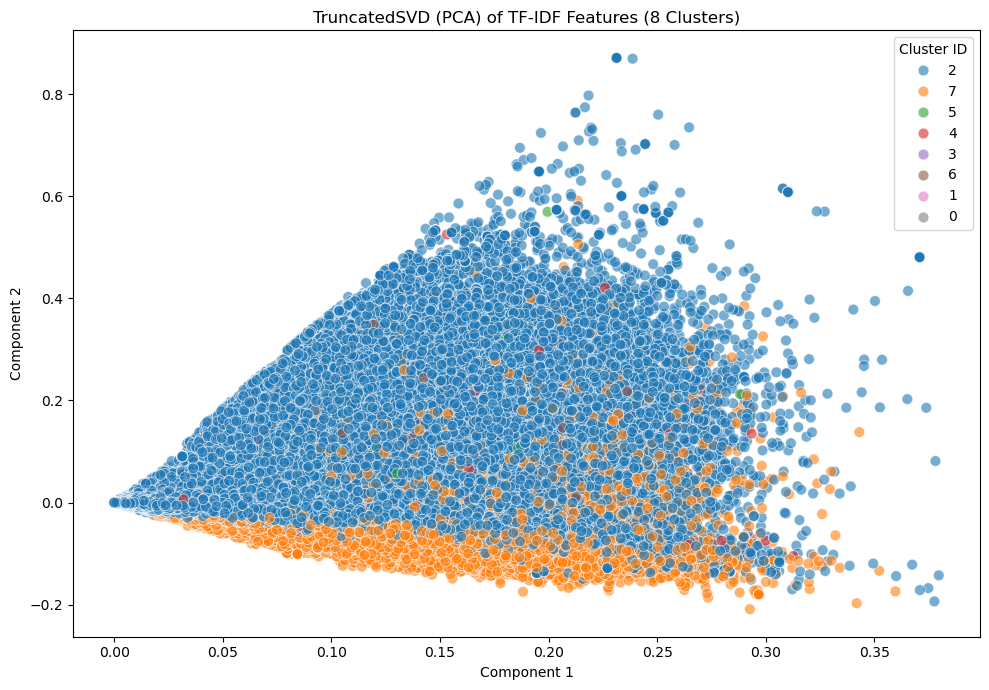

In [15]:
# Idea from chatGPT for visualization - try kmeans clustering to see how well clusters separate and if there's any informative correlation.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: TF-IDF (sparse)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df_cleaned['comment_text'])

# Step 2: TruncatedSVD (PCA-like for sparse)
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# Step 3: KMeans
kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(X_tfidf)
df_cleaned['cluster'] = labels

# Step 4: Plot
df_plot = pd.DataFrame({
    'PC1': X_svd[:, 0],
    'PC2': X_svd[:, 1],
    'Cluster': df_cleaned['cluster'].astype(str)
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60, alpha=0.6)
plt.title("TruncatedSVD (PCA) of TF-IDF Features (8 Clusters)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster ID")
plt.tight_layout()
plt.show()


The above PCA is the result of an idea from chatGPT on how else we could visualize our data.  By separating into our known number of clusters (8 total including the majority non-toxic), we can see that non-toxic dominates, but there's an interesting trend with category 7 as well.  The rest are all scattered, which makes sense, since all of these toxic posts will likely have similar key words or characteristics no matter if they are insulting, obscene, etc.  It would require a lot more semantic work to distill these clusters down to separate issues, especially given their sparsity in the data.

We did a little extra work trying to write out the "top" comments for each cluster in an attempt to make "human" labels manually based on our known categories, but omitted that from this report given the high degree of difficulty in choosing which category was which based on a few readings of comments.  This shows that we have our work cut out for us as we take the next steps towards using BERT and NLP for specific sentiment classification and analysis.

### Baseline Model Implementation Plan

Because the only feature we could use is the user comment, we can treat this problem as a NLP classification problem. We plan to use a version of BERT (e.g. DistilBERT) as the baseline for classification. The BERT model’s attention mechanism allows it to understand the entire comment, and is the most commonly used model for NLP classification in the industry.



In terms of Train/Test data, we noticed that the dataset is highly imbalanced. Hence, we currently plan to oversample positive samples. We could use LLM to rewrite the positive samples, so we increase the variety of our positive sample dataset. Eventually, we aim to have a positive:negative ratio of 1:3.


In terms of evaluation, because the dataset is imbalanced, metrics such as binary cross entropy loss are less effective at measuring the effectiveness of the model. We should focus more on the following metrics:


- Normalized entropy, defined as:

$$\text{Normalized Entropy} = \frac{\text{CrossEntropy(Model)}}{\text{CrossEntropy(Baseline)}}$$
 The baseline model is a naive model that predicts $p$ as the average probability over the training dataset. This loss deals with class imbalance better. For example, if there is 1% positive data and 99% negative data, CrossEntropy(Baseline) would already be pretty low. Normalized Entropy would account for this issue. 

- Precision $$\frac{TP}{\text{(TP+FP)}}$$
- Recall  $$\frac{TP}{\text{(TP+FN)}}$$
- F1 score
- Area Under the Precision-Recall Curve (AUPRC)



How do we decide the correct threshold to classify whether a comment is toxic? We think that the choice depends on how we plan to use the classifier and how much we care about false positives and false negatives. For example, in a production setting, having false positives may result in too many comments being deleted incorrectly, which discourages users from making comments. Having false negatives would result in toxic comments not being flagged/deleted. There are two methods we can try out to decide the threshold:

- Solution 1: Set a minimum recall target (e.g., "We must catch at least 99.5% of all toxic comments”) Find the highest threshold that still meets our minimum recall target.
- Solution 2: Cost-sensitive thresholding. False positives and false negatives have different costs (e.g. false positive=1, false negative=2). Choose a threshold that minimizes the cost.


Lastly, because we oversampled positive labels, our model’s prediction on actual traffic/test dataset would not be well-calibrated: it would predict a positive label more frequently than we expect. We could calculate a weight to be multiplied with model prediction to account for the fact that the training dataset’s label distribution is different from production. An example formula is:


$$p_{\text{true}} = \frac{\alpha \cdot p_{\text{pred}}}{(1 - p_{\text{pred}}) + \alpha \cdot p_{\text{pred}}}$$


where alpha is the ratio of how much we have downsampled negative samples.


### Updated Research Question

How can we predict the toxicity of online comments, identify the factors contributing to toxicity, and evaluate the fairness of our model across different identity attributes?